In [1]:
import scipy
from scipy.io import loadmat
from pandas import factorize
import os
import pickle
import numpy as np
import random

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import os
import scipy.io
import numpy as np

def load_dataset(data, snr_range):
    """
    This function loads and processes a dataset represented as a dictionary with keys as tuples of channel codes and SNR values.

    Parameters:
    - data: A dictionary where keys are tuples representing channel codes and SNR values, and values are corresponding data arrays.
    - snr_range: A tuple specifying the range of SNR values to consider.

    Returns:
    A tuple containing:
    - snrs: List of sorted SNR values within the specified range.
    - X: Stacked data arrays corresponding to each channel code and SNR.
    - ch_codes: List of sorted channel codes.
    - one_hot_encode: One-hot encoded representation of channel codes.
    - lbl_SNR: Array of SNR values corresponding to each data vector.
    """

    # 각 ndarray 요소를 set으로 변환하여 정렬
    ch_codes = sorted(set([key[0] for key in data.keys()]))

    # 각 ndarray 요소를 set으로 변환하여 정렬
    snrs = sorted(set([key[1] for key in data.keys() if snr_range[0] <= key[1] <= snr_range[1]]))


    X = []; I = []; Q = []; lbl = [];

    for ch_code in ch_codes:
        for snr in snrs:
            X.append(data[(ch_code, snr)])
            for i in range(data[(ch_code, snr)].shape[0]):
                lbl.append((ch_code, snr))

    X = np.vstack(X); lbl=np.vstack(lbl)

    print(X.shape)

    # X = np.transpose(X[:,:,:],(0,2,1))


    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        ch_code = (lbl[i,0])
        Y.append(ch_code)

    mapping = {}
    for x in range(len(ch_codes)):
        mapping[ch_codes[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(ch_codes)/len(snrs)
    repeat_n_ch_code = len(ch_codes)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_ch_code)

    return snrs, X, ch_codes, one_hot_encode, lbl_SNR

In [3]:
def train_test_valid_split(X, one_hot, train_split=0.8, valid_split=0.1, test_split=0.1):

    """
    Train-Test-Valid split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.8)
        valid_split (default 0.1)
        test_split (default 0.1)
        train_split : valid_split : test_split - ratio for splitting the dataset

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [5]:
def SNR_accuracy(in_snr, model, name):
    """
    Computes accuracies of chosen SNRs individualy

    INPUT : 
        in_snr: It means SNR_RANGE.  must be list of SNRs
        model : Trained model 
        name : Model name
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 21, 2)
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10)
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=10)


    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-21, 21)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
  
    plt.show()

    return acc[:,1]

In [6]:
CH_CODE = ["CONV_5_7", "CONV_13_17", "CONV_23_35"]
classes = CH_CODE

In [7]:
import os
import re
from tqdm import tqdm
from PIL import Image
import numpy as np
import gc

# SNR 범위 
snr = range(-20, 21, 1)

# 데이터셋 저장 절대경로
dataset_dir = r"C:\Users\USER-PC\haneol\DATASET_IMG" # PYTHON VERSION - IMG

DATA_DICT = {}

for i in tqdm(snr, desc="Loading Files"):
    print("Now load SNR: " + str(i))

    base_dir = os.path.join(dataset_dir, str(i))

    label_data = {}

    # 디렉토리 내의 모든 .jpg 파일 목록 가져오기
    files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

    # 각 .jpg 파일에 대해
    for file in tqdm(files, desc=f"SNR {i}", position=0, leave=False):
        # 절대 경로 생성하기
        filepath = os.path.join(base_dir, file)

        # 이미지 열기
        with Image.open(filepath) as image:
            # 이미지를 넘파이 배열로 변환
            image_data = np.array(image)

        # ch_code 값 추출하기 (예시: 문자열로 변환하여 추출)
        ch_code_value = re.sub(r'_\d+\.jpg', '', file)

        # Key에 따라 저장
        key = (ch_code_value, i)
        if key not in label_data:
            label_data[key] = [image_data]
        else:
            label_data[key].append(image_data)

    # 넘파이 배열로 변환된 이미지 데이터를 딕셔너리에 저장
    for key in label_data.keys():
        if key not in DATA_DICT:
            DATA_DICT[key] = np.stack(label_data[key], axis=0)
        else:
            DATA_DICT[key] = np.concatenate([DATA_DICT[key], np.stack(label_data[key], axis=0)], axis=0)
    
    # 가비지 컬렉션 강제 수행
    del label_data
    gc.collect()



Loading Files:   0%|          | 0/41 [00:00<?, ?it/s]

Now load SNR: -20


Loading Files:   2%|▏         | 1/41 [00:01<00:54,  1.35s/it] 

Now load SNR: -19


Loading Files:   5%|▍         | 2/41 [00:02<00:52,  1.34s/it] 

Now load SNR: -18


Loading Files:   7%|▋         | 3/41 [00:04<00:51,  1.35s/it] 

Now load SNR: -17


Loading Files:  10%|▉         | 4/41 [00:05<00:50,  1.36s/it] 

Now load SNR: -16


Loading Files:  12%|█▏        | 5/41 [00:06<00:49,  1.37s/it] 

Now load SNR: -15


Loading Files:  15%|█▍        | 6/41 [00:08<00:47,  1.36s/it] 

Now load SNR: -14


Loading Files:  17%|█▋        | 7/41 [00:09<00:46,  1.37s/it] 

Now load SNR: -13


Loading Files:  20%|█▉        | 8/41 [00:10<00:44,  1.36s/it] 

Now load SNR: -12


Loading Files:  22%|██▏       | 9/41 [00:12<00:43,  1.36s/it] 

Now load SNR: -11


Loading Files:  24%|██▍       | 10/41 [00:13<00:41,  1.35s/it]

Now load SNR: -10


Loading Files:  27%|██▋       | 11/41 [00:14<00:40,  1.34s/it]

Now load SNR: -9


Loading Files:  29%|██▉       | 12/41 [00:16<00:38,  1.34s/it]

Now load SNR: -8


Loading Files:  32%|███▏      | 13/41 [00:17<00:37,  1.34s/it]

Now load SNR: -7


Loading Files:  34%|███▍      | 14/41 [00:18<00:36,  1.34s/it]

Now load SNR: -6


Loading Files:  37%|███▋      | 15/41 [00:20<00:34,  1.33s/it]

Now load SNR: -5


Loading Files:  39%|███▉      | 16/41 [00:21<00:33,  1.33s/it]

Now load SNR: -4


Loading Files:  41%|████▏     | 17/41 [00:22<00:31,  1.33s/it]

Now load SNR: -3


Loading Files:  44%|████▍     | 18/41 [00:24<00:30,  1.33s/it]

Now load SNR: -2


Loading Files:  46%|████▋     | 19/41 [00:25<00:29,  1.33s/it]

Now load SNR: -1


Loading Files:  49%|████▉     | 20/41 [00:26<00:27,  1.33s/it]

Now load SNR: 0


Loading Files:  51%|█████     | 21/41 [00:28<00:26,  1.33s/it]

Now load SNR: 1


Loading Files:  54%|█████▎    | 22/41 [00:29<00:25,  1.33s/it]

Now load SNR: 2


Loading Files:  56%|█████▌    | 23/41 [00:30<00:24,  1.34s/it]

Now load SNR: 3


Loading Files:  59%|█████▊    | 24/41 [00:32<00:22,  1.34s/it]

Now load SNR: 4


Loading Files:  61%|██████    | 25/41 [00:33<00:21,  1.34s/it]

Now load SNR: 5


Loading Files:  63%|██████▎   | 26/41 [00:34<00:20,  1.33s/it]

Now load SNR: 6


Loading Files:  66%|██████▌   | 27/41 [00:36<00:18,  1.33s/it]

Now load SNR: 7


Loading Files:  68%|██████▊   | 28/41 [00:37<00:17,  1.33s/it]

Now load SNR: 8


Loading Files:  71%|███████   | 29/41 [00:38<00:16,  1.34s/it]

Now load SNR: 9


Loading Files:  73%|███████▎  | 30/41 [00:40<00:14,  1.34s/it]

Now load SNR: 10


Loading Files:  76%|███████▌  | 31/41 [00:41<00:13,  1.34s/it]

Now load SNR: 11


Loading Files:  78%|███████▊  | 32/41 [00:42<00:12,  1.34s/it]

Now load SNR: 12


Loading Files:  80%|████████  | 33/41 [00:44<00:10,  1.34s/it]

Now load SNR: 13


Loading Files:  83%|████████▎ | 34/41 [00:45<00:09,  1.35s/it]

Now load SNR: 14


Loading Files:  85%|████████▌ | 35/41 [00:46<00:08,  1.35s/it]

Now load SNR: 15


Loading Files:  88%|████████▊ | 36/41 [00:48<00:06,  1.35s/it]

Now load SNR: 16


Loading Files:  90%|█████████ | 37/41 [00:49<00:05,  1.34s/it]

Now load SNR: 17


Loading Files:  93%|█████████▎| 38/41 [00:50<00:04,  1.34s/it]

Now load SNR: 18


Loading Files:  95%|█████████▌| 39/41 [00:52<00:02,  1.34s/it]

Now load SNR: 19


Loading Files:  98%|█████████▊| 40/41 [00:53<00:01,  1.34s/it]

Now load SNR: 20


Loading Files: 100%|██████████| 41/41 [00:54<00:00,  1.34s/it]


In [8]:
SNR, X, Ch_Codes, one_hot, lbl_SNR = load_dataset(DATA_DICT, (-20, 20))

(61500, 1, 128)


In [9]:
X = X.reshape(-1, 1, 128, 1)

In [10]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.8, valid_split=0.1, test_split=0.1)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# CNN 1

In [37]:
# Kernel size / Filter size = 2

cnn_in = keras.layers.Input(shape=(1, 128, 1))

cnn = keras.layers.Conv2D(filters=32, kernel_size=(1, 2), activation='relu')(cnn_in) 
cnn = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Conv2D(filters=32, kernel_size=(1, 2), activation='relu')(cnn)  
cnn = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Conv2D(filters=16, kernel_size=(1, 2), activation='relu')(cnn)  
cnn = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn)
cnn = keras.layers.Dropout(rate=0.2)(cnn)

cnn = keras.layers.Flatten()(cnn) # (None, 240) 
cnn = keras.layers.Dense(120, activation='relu')(cnn)
cnn = keras.layers.Dense(60, activation='relu')(cnn)

cnn_out = keras.layers.Dense(len(classes), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [39]:
model_cnn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 127, 32)     │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 62, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 30, 16)      │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 15, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 15, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │        28,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,579 (154.61 KB)

 Trainable params: 39,579 (154.61 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model_cnn.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid, Y_valid), callbacks=[es, rlrop])

Epoch 1/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3313 - loss: 4.6412 - val_accuracy: 0.3353 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3336 - loss: 1.1145 - val_accuracy: 0.3283 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3379 - loss: 1.1026 - val_accuracy: 0.3289 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 4/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3345 - loss: 1.1014 - val_accuracy: 0.3341 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 5/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3314 - loss: 1.1009 - val_accuracy: 0.3413 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 6/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3364 - loss: 1.0999 - val_accuracy: 0.3319 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 7/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3394 - loss: 1.

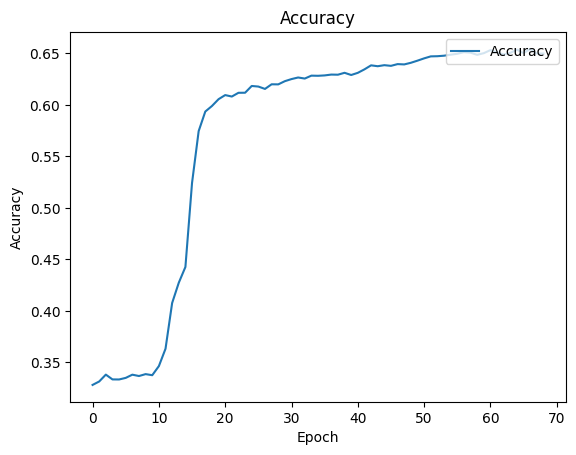

In [41]:
# Acc의 추이 확인
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'], loc='upper right')
plt.show()


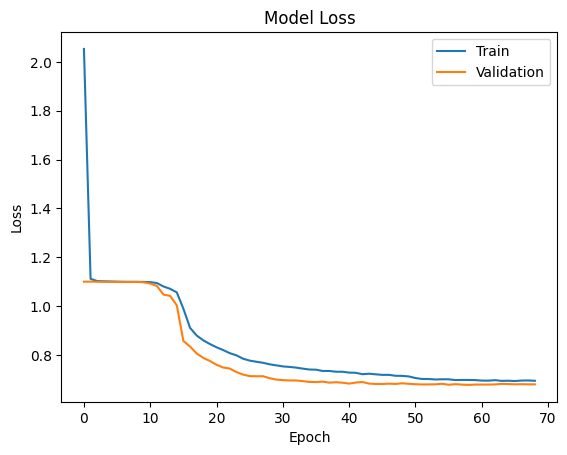

In [42]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


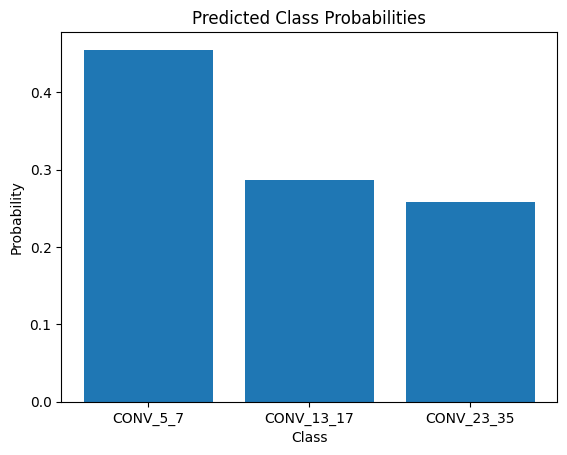

In [43]:
# Check predict calsprobabilities
Y_predict = model_cnn.predict(X_test)

result_array = np.array(Y_predict)

class_labels = classes

rand = random.randrange(0, len(Y_predict)-1)

# 막대 그래프 생성
plt.bar(class_labels, result_array[rand])

# 축 및 제목 설정
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')

# 그래프 출력
plt.show()

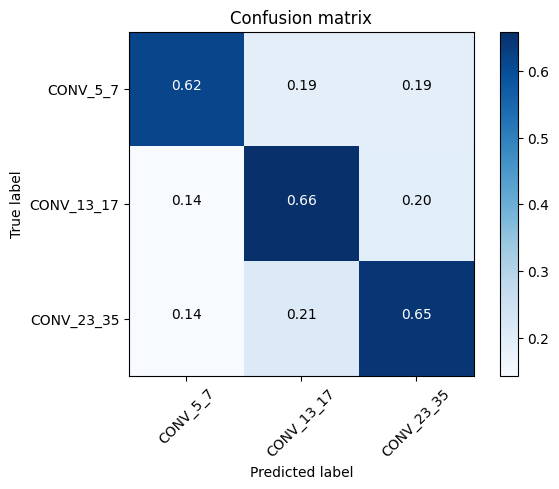

In [44]:
# Calculate confusion matrix
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Plot confusion matrix
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
5/5 - 0s - 34ms/step - accuracy: 0.2600 - loss: 1.1755

SNR -19dB:
5/5 - 0s - 6ms/step - accuracy: 0.3247 - loss: 1.1372

SNR -18dB:
5/5 - 0s - 7ms/step - accuracy: 0.3311 - loss: 1.1563

SNR -17dB:
6/6 - 0s - 5ms/step - accuracy: 0.3529 - loss: 1.1519

SNR -16dB:
5/5 - 0s - 7ms/step - accuracy: 0.3778 - loss: 1.1396

SNR -15dB:
5/5 - 0s - 6ms/step - accuracy: 0.4027 - loss: 1.1611

SNR -14dB:
6/6 - 0s - 5ms/step - accuracy: 0.3314 - loss: 1.2063

SNR -13dB:
5/5 - 0s - 4ms/step - accuracy: 0.3562 - loss: 1.1533

SNR -12dB:
4/4 - 0s - 8ms/step - accuracy: 0.2672 - loss: 1.1592

SNR -11dB:
5/5 - 0s - 6ms/step - accuracy: 0.3425 - loss: 1.1608

SNR -10dB:
6/6 - 0s - 6ms/step - accuracy: 0.3148 - loss: 1.1424

SNR -9dB:
6/6 - 0s - 6ms/step - accuracy: 0.3526 - loss: 1.1478

SNR -8dB:
5/5 - 0s - 6ms/step - accuracy: 0.3194 - loss: 1.1695

SNR -7dB:
5/5 - 0s - 9ms/step - accuracy: 0.3923 - loss: 1.1039

SNR -6dB:
5/5 - 0s - 6ms/step - accuracy: 0.3608 - loss: 1.1574

SNR -5dB:
5/

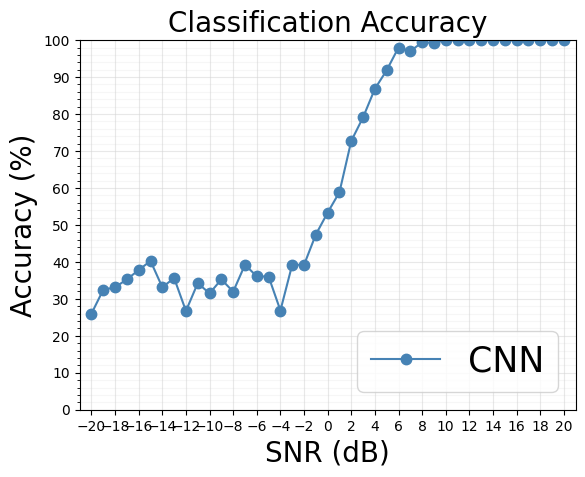

In [45]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snr, model_cnn, 'CNN')

# CNN 2

In [14]:
# Kernel size / Filter size = 4

cnn_in_2 = keras.layers.Input(shape=(1, 128, 1)) # (None, 1, 128, 1)

cnn_2 = keras.layers.Conv2D(filters=32, kernel_size=(1, 4), activation='relu')(cnn_in_2)  # (None, 1, 125, 32) 
# cnn_2 = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn_2) # (None, 1, 62, 32) 
cnn_2 = keras.layers.Dropout(rate=0.2)(cnn_2) # (None, 1, 62, 32)

cnn_2 = keras.layers.Conv2D(filters=32, kernel_size=(1, 4), activation='relu')(cnn_2) # (None, 1, 59, 32) 
# cnn_2 = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn_2) # (None, 1, 29, 32) 
cnn_2 = keras.layers.Dropout(rate=0.2)(cnn_2) # (None, 1, 29, 32) 

cnn_2 = keras.layers.Conv2D(filters=16, kernel_size=(1, 4), activation='relu')(cnn_2) # (None, 1, 26, 16)      
# cnn_2 = keras.layers.MaxPool2D(pool_size=(1, 2))(cnn_2) # (None, 1, 13, 16)  
cnn_2 = keras.layers.Dropout(rate=0.2)(cnn_2) # (None, 1, 13, 16) 

cnn_2 = keras.layers.Flatten()(cnn_2) # (None, 208) -> (None, 1904)
cnn_2 = keras.layers.Dense(500, activation='relu')(cnn_2) # (None, 500) 
cnn_2 = keras.layers.Dense(50, activation='relu')(cnn_2) # (None, 50)

cnn_out_2 = keras.layers.Dense(len(classes), activation='softmax')(cnn_2)

model_cnn_2 = keras.models.Model(cnn_in_2, cnn_out_2)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
model_cnn_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 125, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 125, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 122, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 122, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 119, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 119, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1904)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       952,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,055 (3.75 MB)

 Trainable params: 984,055 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_2 = model_cnn_2.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid, Y_valid), callbacks=(es, rlrop))

Epoch 1/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3282 - loss: 3.5820 - val_accuracy: 0.3364 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3315 - loss: 1.0987 - val_accuracy: 0.3358 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3359 - loss: 1.0987 - val_accuracy: 0.3372 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 4/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3295 - loss: 1.0987 - val_accuracy: 0.3296 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 5/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3316 - loss: 1.0987 - val_accuracy: 0.3299 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 6/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3372 - loss: 1.0987 - val_accuracy: 0.3298 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 7/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3395 - l

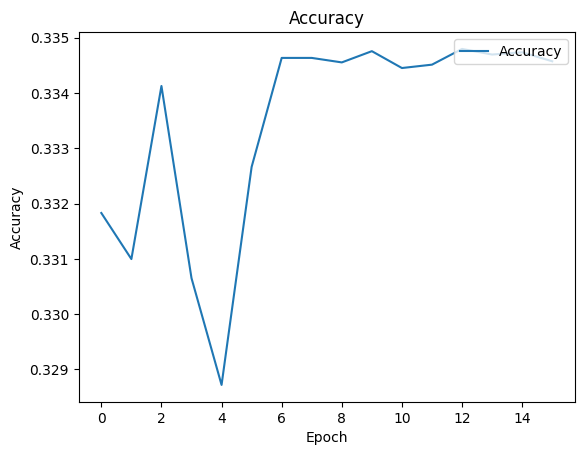

In [17]:
# Acc의 추이 확인
plt.plot(history_2.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

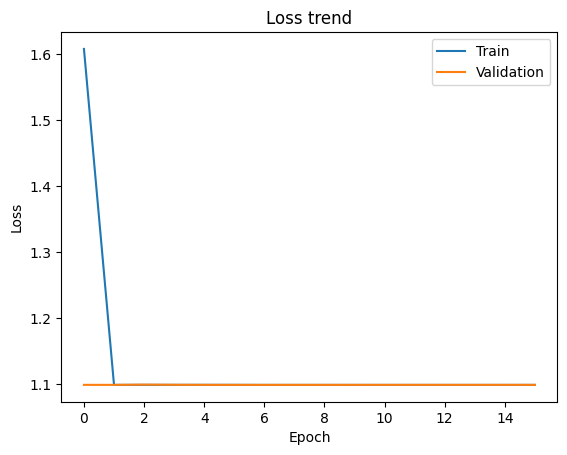

In [19]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Loss trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


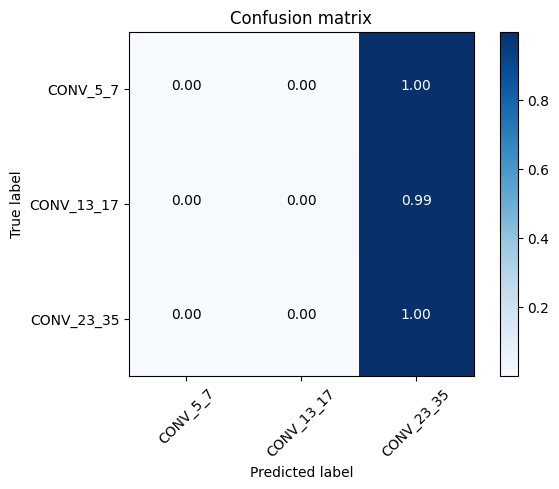

In [21]:
Y_predict_2 = model_cnn_2.predict(X_test)

# Calculate confusion matrix
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(Y_predict_2[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Plot confusion matrix
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
5/5 - 0s - 34ms/step - accuracy: 0.3133 - loss: 1.0986

SNR -19dB:
5/5 - 0s - 5ms/step - accuracy: 0.3442 - loss: 1.0986

SNR -18dB:
5/5 - 0s - 7ms/step - accuracy: 0.3514 - loss: 1.0984

SNR -17dB:
6/6 - 0s - 6ms/step - accuracy: 0.3294 - loss: 1.0992

SNR -16dB:
5/5 - 0s - 6ms/step - accuracy: 0.3111 - loss: 1.0989

SNR -15dB:
5/5 - 0s - 6ms/step - accuracy: 0.2953 - loss: 1.0988

SNR -14dB:
6/6 - 0s - 7ms/step - accuracy: 0.3198 - loss: 1.0986

SNR -13dB:
5/5 - 0s - 7ms/step - accuracy: 0.4313 - loss: 1.0982

SNR -12dB:
4/4 - 0s - 6ms/step - accuracy: 0.3362 - loss: 1.0984

SNR -11dB:
5/5 - 0s - 7ms/step - accuracy: 0.2877 - loss: 1.0988

SNR -10dB:
6/6 - 0s - 5ms/step - accuracy: 0.3395 - loss: 1.0988

SNR -9dB:
6/6 - 0s - 4ms/step - accuracy: 0.3526 - loss: 1.0986

SNR -8dB:
5/5 - 0s - 5ms/step - accuracy: 0.3194 - loss: 1.0985

SNR -7dB:
5/5 - 0s - 6ms/step - accuracy: 0.3154 - loss: 1.0989

SNR -6dB:
5/5 - 0s - 6ms/step - accuracy: 0.2975 - loss: 1.0988

SNR -5dB:
5/

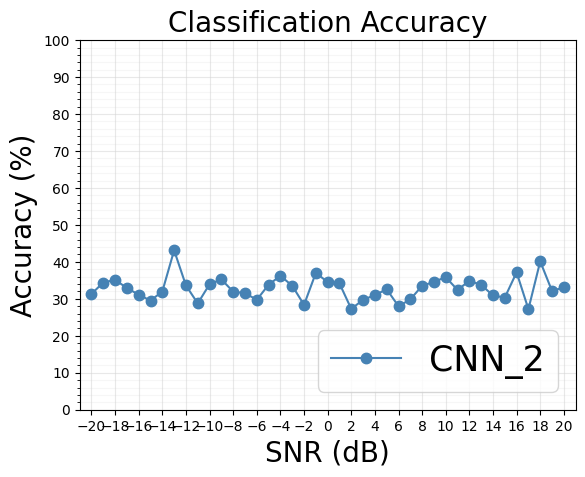

In [22]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snr, model_cnn_2, 'CNN_2')